In [31]:
import os
import pandas as pd
import numpy as np
import spacy
import re

from string import punctuation

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from pymorphy3 import MorphAnalyzer

from nltk import ngrams
from nltk.corpus import stopwords


from functools import lru_cache

import seaborn as sns

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from catboost import EFstrType

In [2]:
df = pd.read_csv("data/workshop1_lemmatized_data.csv", engine='python')

## Анализ

In [3]:
df.head()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lemmatized
0,0,"D'Оо! Он соответствует этому цвету фона, с кот...",0,0,0,0,0,0,dоо он соответствовать этот цвет фон который п...
1,1,"""\n\nПоздравляю и меня, хорошо использую инстр...",0,0,0,0,0,0,поздравлять использовать инструмент · разговар...
2,2,Смысл Mitsurugi не имеет смысла - почему бы не...,0,0,0,0,0,0,смысл mitsurugi не иметь смысл почему не поспо...
3,3,"О, и девушка выше начала свои споры со мной. О...",0,0,0,0,0,0,о девушка выше начало свой спор я она сунуть н...
4,4,"До свидания!\nНе смотри, приходи или думай о в...",1,0,0,0,0,0,до свидание не смотреть приходить думать возвр...


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df = df.dropna()

In [6]:
df['toxic'].value_counts()

toxic
0    201567
1     21331
Name: count, dtype: int64

In [7]:
df['obscene'].value_counts()

obscene
0    210799
1     12099
Name: count, dtype: int64

In [8]:
df['identity_hate'].value_counts()

identity_hate
0    220788
1      2110
Name: count, dtype: int64

In [9]:
targets = df.drop(['comment_text', 'lemmatized'], axis=1)
corr = targets.corr()

<Axes: >

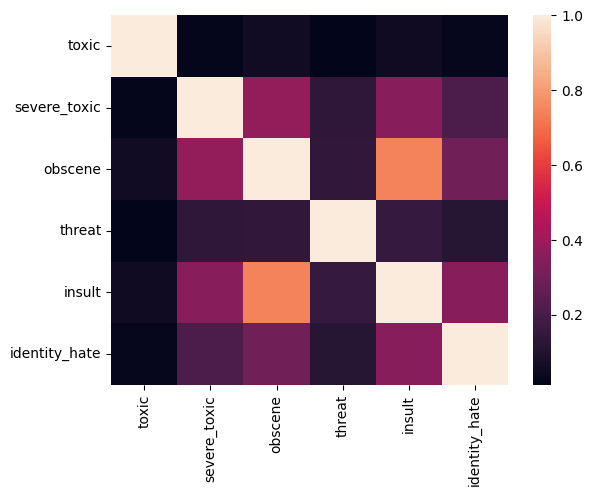

In [10]:
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Мат

In [11]:
X = df.drop(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
y = df['obscene']

In [12]:
y.value_counts()

obscene
0    210799
1     12099
Name: count, dtype: int64

In [13]:
y.info()

<class 'pandas.core.series.Series'>
Index: 222898 entries, 0 to 222910
Series name: obscene
Non-Null Count   Dtype
--------------   -----
222898 non-null  int64
dtypes: int64(1)
memory usage: 3.4 MB


In [14]:
pd.options.display.max_columns = None
print(X[y == 1].head(20))

                                            lemmatized
6              вы сэр герой есть шанс помнить страница
42   первый послание войдать поп георгиев чернодрин...
43   радиальный симметрия несколько ныне вымереть л...
51   bi сказать хотеть поговорить в нижний часть ве...
55   облом привет заметить твой комментарий страниц...
56   тони сидавей очевидный тупица он любить рука з...
58   апрель 2006 спасибо эксперимент страница энди ...
65   parzival418 пытаться напугать это как мочь ска...
105  также думать vegetable basket нужный свой стра...
176  29 август 2006 г вау понимать отправка который...
181  и пайзер просто социальный антрополог он чей н...
201  надёжный источник указывать обратный пожалуйст...
211  ну быть использовать мой страница пользователь...
218  убить негр я тяжело другой говорить это это до...
231  новый пользователь привет гий додый я новый по...
238  удаление аккаунт ok blueboy редактирование l31...
295  изображение popclassicjpg я пометить image pop...
298  возмо

In [15]:
buzzwords1 = pd.read_csv('data/words.txt', header=None)
buzzwords1.columns = ['word']
buzzwords1

,word
0,анус
1,аборт
2,бздун
3,беспезды
4,бздюх
...,...
1312,отьебись
1313,спам
1314,spam
1315,мудила


In [16]:
buzzwords2 = pd.read_csv('data/buzzwords.txt', header=None, encoding="cp1251")
buzzwords2.columns = ['word']
buzzwords2

,word
0,авотхуй
1,ахуеть
2,безпезды
3,безпизды
4,бля
...,...
256,хуярить
257,хуячить
258,чмо
259,чмошник


In [17]:
filter_banned_russian = pd.read_csv('data/filter_banned_russian.txt', header=None)
filter_banned_russian.columns = ['word']
filter_banned_russian

,word
0,педерастический
1,однодырочники
2,педерастина
3,пиндостанцы
4,говносерка
...,...
108,\w*пидрила\w*
109,\w*дoлбaёб\w*
110,\w*ослаеб\w*
111,\w*пидар\w*


In [18]:
filter_profanity_russian = pd.read_csv('data/filter_profanity_russian.txt', header=None)
filter_profanity_russian.columns = ['word']
filter_profanity_russian

,word
0,заебитесьвывротивжопу
1,заебисьонвротивжопу
2,заебисьтывротивжопу
3,едрижтвоювбабушку
4,перемандовываться
...,...
1956,\w*уебал\w*
1957,\w*пизд\w*
1958,\w*пизж\w*
1959,\w*хуи\w*


In [19]:
custom_buzzwords = pd.read_csv('data/custom_buzzwords.txt', header=None)
custom_buzzwords.columns = ['word']
custom_buzzwords

,word
0,педик
1,сосать
2,дерьмо
3,пенис
4,гей
5,nigger


In [20]:
buzzwords = pd.concat([buzzwords1, buzzwords2, filter_banned_russian, filter_profanity_russian, custom_buzzwords])
buzzwords


,word
0,анус
1,аборт
2,бздун
3,беспезды
4,бздюх
...,...
1,сосать
2,дерьмо
3,пенис
4,гей


In [21]:
y_pred = X['lemmatized'].isin(buzzwords['word'].to_list())

In [22]:
y_pred = y_pred.astype('int8')

In [23]:
y_pred.value_counts()

lemmatized
0    222869
1        29
Name: count, dtype: int64

матерных слов в тексте не обнаружено

Попробуем обучить модели

In [24]:
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=0.2, random_state=42,
                                                   )
print(df.shape), print(test_x.shape), print(test_x.shape),

(222898, 8)
(44580, 1)
(44580, 1)


(None, None, None)

In [25]:
text_features = ['lemmatized']

In [26]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178318 entries, 142409 to 121960
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lemmatized  178318 non-null  object
dtypes: object(1)
memory usage: 2.7+ MB


In [27]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='Logloss',
                                thread_count=-1, 
                                random_seed=42, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
                                
)


model_cb.fit(train_x, train_y, text_features=text_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
print(classification_report(test_y,test_pred)) 


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     42200
           1       1.00      0.00      0.00      2380

    accuracy                           0.95     44580
   macro avg       0.97      0.50      0.49     44580
weighted avg       0.95      0.95      0.92     44580

